In [1]:
from gams.transfer import Container
import pandas as pd
from utils import read_gdx,read_scenarios
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os

In [131]:
def read_gdx(path_gdx: str,vars,initial_year=2010,tstep=5):
    """Read the gdx
    path_gdx: path to file .gdx
    var: str of variable to read
    initial_year: start of model
    tstep of model (years)

    Returns dataframe
    """
    gdx = Container(path_gdx)

    df = gdx[vars[0]].records.drop(columns=['marginal','lower','upper','scale'])
    df.rename(columns={'level':vars[0]},inplace=True)
    for i,var in enumerate(vars):
        if i != 0:
            df[var] = gdx[var].records['level']

    df['t_0'] = df['t_0'].astype('int')
    df['year'] = initial_year + tstep*(df['t_0']-1)
    if 'n_1' in df.columns:
        df['n_1'] = df['n_1'].astype(str)
        df.rename(columns={'n_1':'region'},inplace=True)
    return df

def read_scenarios(paths,vars,initial_year=2010,tstep=5):
    df_old = pd.DataFrame()

    for path in paths:
        df_new = read_gdx(path,vars,initial_year,tstep)
        df_new['scen'] = path.replace("results/results_","").replace(".gdx","")
        df_old = pd.concat([df_old,df_new])
        
    return df_old

In [49]:
path1 = 'results/results_burke_coop_cbudget800.gdx'
path2 = 'results/results_burke_coop_cbudget1000.gdx'
#path1 = 'results/results_budget_800.gdx'
#path2 = 'results/results_budget_1000.gdx'
gdx = Container(path1)
print(gdx.listVariables())

['C', 'CPC', 'K', 'I', 'S', 'RI', 'YGROSS', 'YNET', 'Y', 'CTX', 'E', 'EIND', 'MIU', 'ABATEDEMI', 'CCO2EIND', 'CCO2ETOT', 'UTILITY', 'ABATECOST', 'CPRICE', 'ABATECOST_PB', 'ABATECOST_ED', 'CPRICE_ED', 'CPRICE_PB', 'ELAND', 'FORC', 'TATM', 'TOCEAN', 'W_EMI', 'WCUM_EMI', 'RF', 'RFoth', 'TEMP_REGION', 'TEMP_REGION_DAM', 'DAMAGES', 'DAMFRAC', 'YNET_ESTIMATED', 'BIMPACT', 'OMEGA', 'KOMEGA']


In [132]:
data = read_scenarios([path1,path2],['E','ABATEDEMI','TEMP_REGION','TEMP_REGION_DAM','DAMAGES','DAMFRAC'])
data

,t_0,region,E,ABATEDEMI,TEMP_REGION,TEMP_REGION_DAM,DAMAGES,DAMFRAC,year,scen
0,1,r5asia,15.769330,0.000000e+00,20.152972,20.152972,-7.428014e-11,2.206302e-12,2010,burke_coop_cbudget800
1,1,r5lam,3.049388,0.000000e+00,21.789048,21.789048,-2.891003e-10,3.331770e-11,2010,burke_coop_cbudget800
2,1,r5maf,4.401106,0.000000e+00,22.914034,22.914034,-3.269918e-10,4.258465e-11,2010,burke_coop_cbudget800
3,1,r5oecd,11.260201,3.552714e-15,12.193810,12.193810,-6.972556e-11,1.944040e-12,2010,burke_coop_cbudget800
4,1,r5ref,3.169240,0.000000e+00,8.758937,8.758937,-3.217213e-10,4.122848e-11,2010,burke_coop_cbudget800
...,...,...,...,...,...,...,...,...,...,...
285,58,r5asia,1.370430,5.510369e-01,20.256351,20.256351,1.921757e+02,-6.563826e-01,2295,burke_coop_cbudget1000
286,58,r5lam,0.415629,0.000000e+00,21.887934,21.887934,4.309221e+01,-6.784217e-01,2295,burke_coop_cbudget1000
287,58,r5maf,1.740463,7.386181e-01,23.023846,23.023846,2.598973e+02,-7.423845e-01,2295,burke_coop_cbudget1000
288,58,r5oecd,-0.360345,1.195482e+00,12.306835,12.306835,2.354565e+00,-1.505252e-02,2295,burke_coop_cbudget1000


<Axes: xlabel='year', ylabel='DAMAGES'>

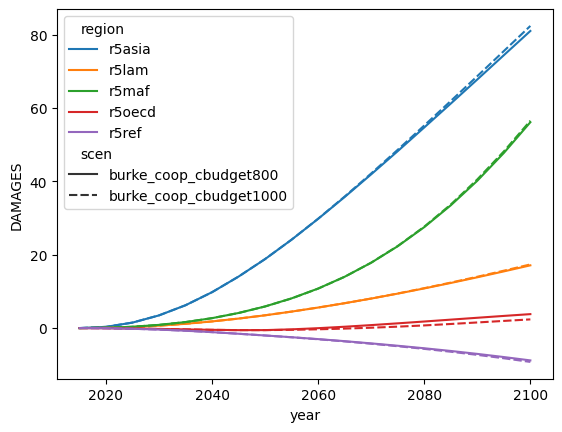

In [56]:
countries=data[(data['year'] <= 2100)]
sns.lineplot(data=countries,x='year',y='DAMAGES',hue='region',style='scen')

In [117]:
scens = ['results/results_budget_800.gdx','results/results_budget_1000.gdx']

cco2etot = read_scenarios(scens,['CCO2ETOT'])
cco2etot = cco2etot[cco2etot['year'] <= 2100]

Emis = read_scenarios(scens,['E'])
cumemis = Emis[Emis['year']<=2100].groupby(['scen','year'])['E'].sum().reset_index()
cumemis['CUMEMI'] = cumemis['E'].cumsum()

joined = pd.merge(cco2etot,cumemis,'inner',['year','scen'])
joined = pd.melt(joined,id_vars=['year','scen'],value_vars=['CCO2ETOT','CUMEMI'],
                 var_name='variable',value_name='CUMEMI')

C:\Users\danip\AppData\Local\Temp\ipykernel_26876\1112070488.py:11: FutureWarning: This dataframe has a column name that matches the 'value_name' column name of the resulting Dataframe. In the future this will raise an error, please set the 'value_name' parameter of DataFrame.melt to a unique name.
  joined = pd.melt(joined,id_vars=['year','scen'],value_vars=['CCO2ETOT','CUMEMI'],


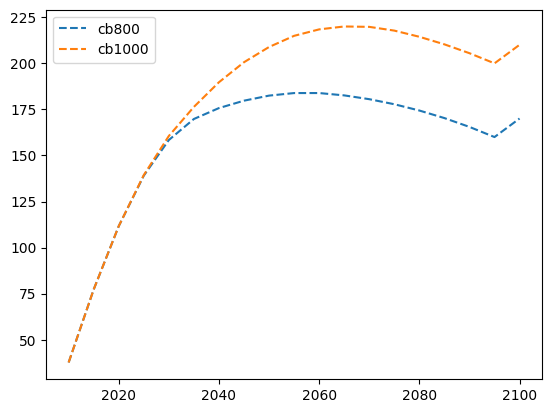

In [195]:
Emis = read_scenarios(scens,['E'])
test = Emis[Emis['year']<=2100]

test1 = test.pivot_table('E',['scen','year'],'region').sum(axis=1).reset_index()
test1 = test1.rename(columns={0:'E'})

cb800 = test1[test1['scen'] == 'budget_800'][['year','E']]
cb1000 = test1[test1['scen'] == 'budget_1000'][['year','E']]

plt.plot(cb800['year'],cb800['E'].cumsum(),'--',label='cb800')
plt.plot(cb1000['year'],cb1000['E'].cumsum(),'--',label='cb1000')
plt.legend()
plt.show()

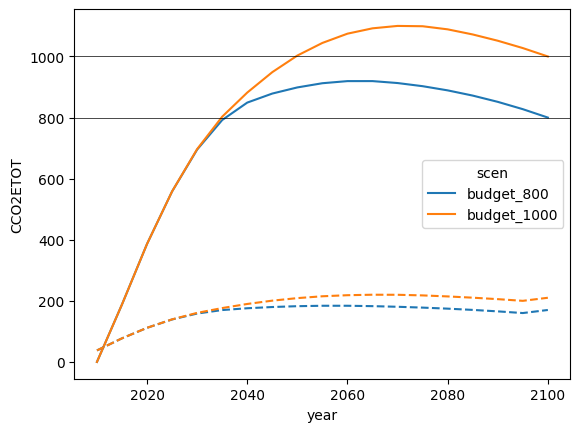

In [200]:
plt.figure()
#sns.lineplot(data=joined,x='year',y='CUMEMI',hue='scen',style='variable')
sns.lineplot(data=cco2etot,x='year',y='CCO2ETOT',hue='scen')
plt.plot(cb800['year'],cb800['E'].cumsum(),'--',c='C0',label='cb800')
plt.plot(cb1000['year'],cb1000['E'].cumsum(),'--',c='C1',label='cb1000')
plt.axhline(800,color='black',linewidth=0.5)
plt.axhline(1000,color='black',linewidth=0.5)
plt.show()

In [127]:
cbudget800 = read_gdx('results/results_budget_800.gdx',['E'])
cbudget800

,t_0,region,E,year
0,1,brazil,0.992109,2010
1,1,canada,0.685443,2010
2,1,china,9.974372,2010
3,1,europe,3.289115,2010
4,1,india,2.192529,2010
...,...,...,...,...
981,58,seasia,0.265580,2295
982,58,southafrica,0.047536,2295
983,58,ssa,3.753244,2295
984,58,te,0.115953,2295


In [58]:
pd.pivot_table(cbudget800[cbudget800['year'] <= 2100],'E','year','region')

region,brazil,canada,china,europe,india,indonesia,jpnkor,laca,mena,mexico,oceania,sasia,seasia,southafrica,ssa,te,usa
year,,,,,,,,,,,,,,,,,
2015,0.992109,0.685443,9.974372,3.289115,2.192529,1.728817,1.801820,1.522437,2.672047,0.534842,0.470796,0.367885,1.277630,0.442041,1.729059,2.733633,5.234691
2020,0.962382,0.683176,12.292903,3.031164,2.784671,1.654536,1.760206,1.561980,2.425409,0.543707,0.466257,0.414584,1.395389,0.442398,1.679638,2.779281,4.747993
2025,0.832384,0.562642,11.344852,2.221063,2.832380,1.514633,1.400531,1.407377,1.944847,0.460164,0.377133,0.392025,1.235962,0.364239,1.564006,2.296943,3.614402
2030,0.689945,0.434063,9.061945,1.478553,2.591516,1.348305,1.024644,1.205655,1.520472,0.365291,0.284025,0.341403,1.006948,0.278696,1.426743,1.746311,2.606664
2035,0.538642,0.302649,5.963989,0.784479,2.026496,1.147029,0.632644,0.947736,1.151131,0.326071,0.189787,0.304377,0.718019,0.186977,1.368481,1.124281,1.632775
2040,0.380366,0.169565,2.586191,0.427834,1.113035,0.903935,0.488163,0.764295,0.962482,0.293882,0.094663,0.274699,0.433810,0.124680,1.310331,0.440746,0.643859
2045,0.234154,0.056160,-0.324311,0.249416,0.706013,0.694321,0.398187,0.664774,0.861902,0.274335,0.065044,0.250573,0.327959,0.102665,1.281049,-0.003755,0.078541
2050,0.207226,0.049702,-0.324311,0.078048,0.226744,0.570355,0.303963,0.539864,0.738899,0.250666,0.035939,0.213713,0.203713,0.077538,1.235857,-0.179142,-0.215006
2055,0.183395,0.043986,-0.324311,-0.107287,0.031587,0.504764,0.205922,0.386718,0.576995,0.221427,0.009042,0.164379,0.061393,0.049945,1.152682,-0.179142,-0.231960
